In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [7]:
data = pd.read_csv("train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [5]:
# Типы переменных
print(data.dtypes)

Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
Class                   int64
dtype: object


In [6]:
# Пропущенные значения
print(data.isnull().sum())

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64


В колонке **instrumentalness** содержится наибольшее число пропущенных значений. Также они есть в колонках **Popularity** и **key**.

In [7]:
# Summary
print(data.describe())

         Popularity  danceability        energy           key      loudness  \
count  17568.000000  17996.000000  17996.000000  15982.000000  17996.000000   
mean      44.512124      0.543433      0.662777      5.952447     -7.910660   
std       17.426928      0.166268      0.235373      3.196854      4.049151   
min        1.000000      0.059600      0.000020      1.000000    -39.952000   
25%       33.000000      0.432000      0.509000      3.000000     -9.538000   
50%       44.000000      0.545000      0.700000      6.000000     -7.016000   
75%       56.000000      0.659000      0.860000      9.000000     -5.189000   
max      100.000000      0.989000      1.000000     11.000000      1.355000   

               mode   speechiness  acousticness  instrumentalness  \
count  17996.000000  17996.000000  17996.000000      13619.000000   
mean       0.636753      0.079707      0.247082          0.177562   
std        0.480949      0.083576      0.310632          0.304048   
min        0

In [8]:
data_numeric = data.drop(data.columns[[0, 1]], axis=1)

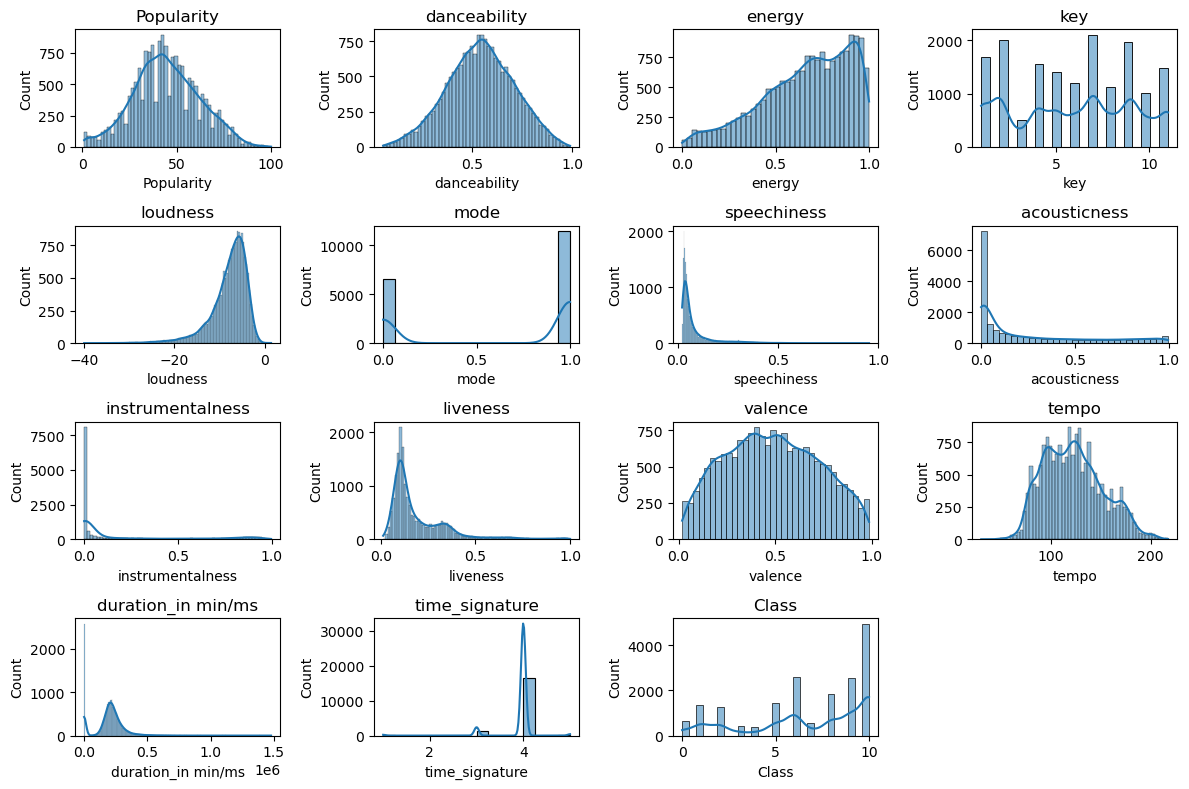

In [13]:
# Посмотрим на распределение числовых переменных
plt.figure(figsize=(12, 8))
for i, column in enumerate(data_numeric.columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(data_numeric[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

В колонках Key и Class наблюдается явный дисбаланс классов

In [14]:
# Баланс классов в процентах
print(data['Class'].value_counts(normalize=True)*100)  # normalize=True to get percentages

10    27.500556
6     14.375417
9     14.025339
8     10.302289
5      8.040676
1      7.629473
2      7.068237
0      3.472994
7      3.200711
3      2.233830
4      2.150478
Name: Class, dtype: float64


Это распределение указывает на то, что набор данных несбалансирован: **класс 10** встречается чаще всего, а **классы 3 и 4** - реже всего.

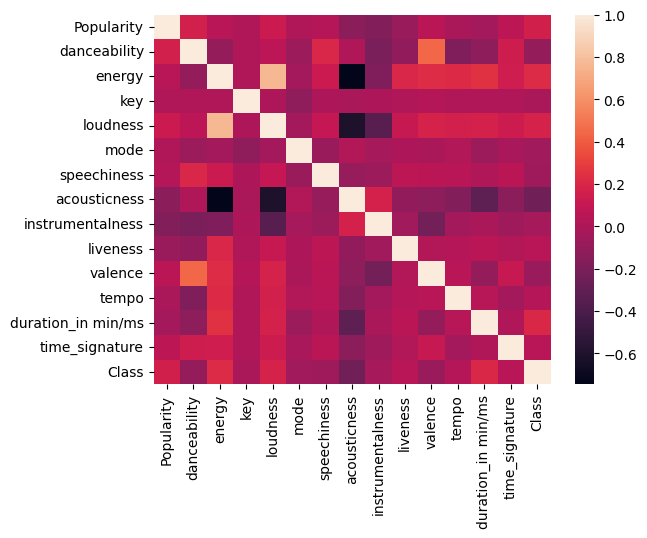

In [15]:
# График корреляции
correlation_matrix = data_numeric.corr()
sns.heatmap(correlation_matrix)
plt.show()

Между собой хорошо коррелируют переменные **energy** и **loudness** (положительная корреляция), а также **energy** и **acousticness** (отрицательная корреляция). Нарисуем для них диаграмму рассеивания.

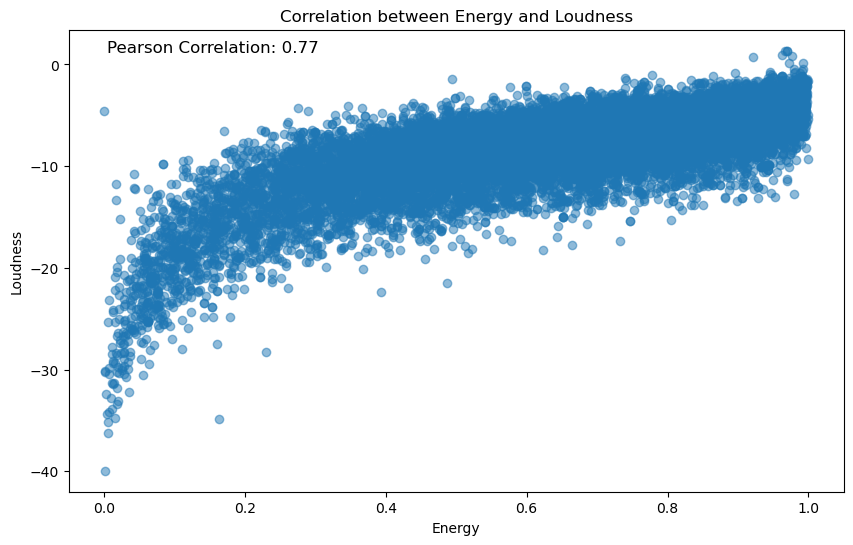

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(data_numeric['energy'], data_numeric['loudness'], alpha=0.5)
plt.title('Correlation between Energy and Loudness')
plt.xlabel('Energy')
plt.ylabel('Loudness')
corr_energy_loudness, _ = pearsonr(data_numeric['energy'], data_numeric['loudness'])
plt.annotate(f'Pearson Correlation: {corr_energy_loudness:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

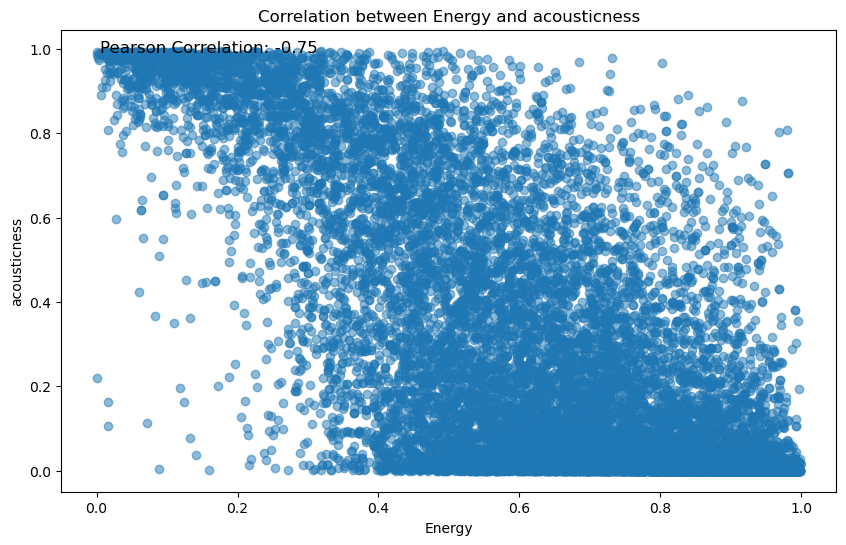

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(data_numeric['energy'], data_numeric['acousticness'], alpha=0.5)
plt.title('Correlation between Energy and acousticness')
plt.xlabel('Energy')
plt.ylabel('acousticness')
corr_energy_acousticness, _ = pearsonr(data_numeric['energy'], data_numeric['acousticness'])
plt.annotate(f'Pearson Correlation: {corr_energy_acousticness:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [11]:
# Class - это целевая переменная
X = data_numeric.drop('Class', axis=1)
y = data_numeric['Class']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Создание модели дерева решений
dt = DecisionTreeClassifier()

# Подбор гиперпараметров с использованием GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Получение лучших параметров и модели
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(accuracy, 3)}')

Accuracy: 0.486


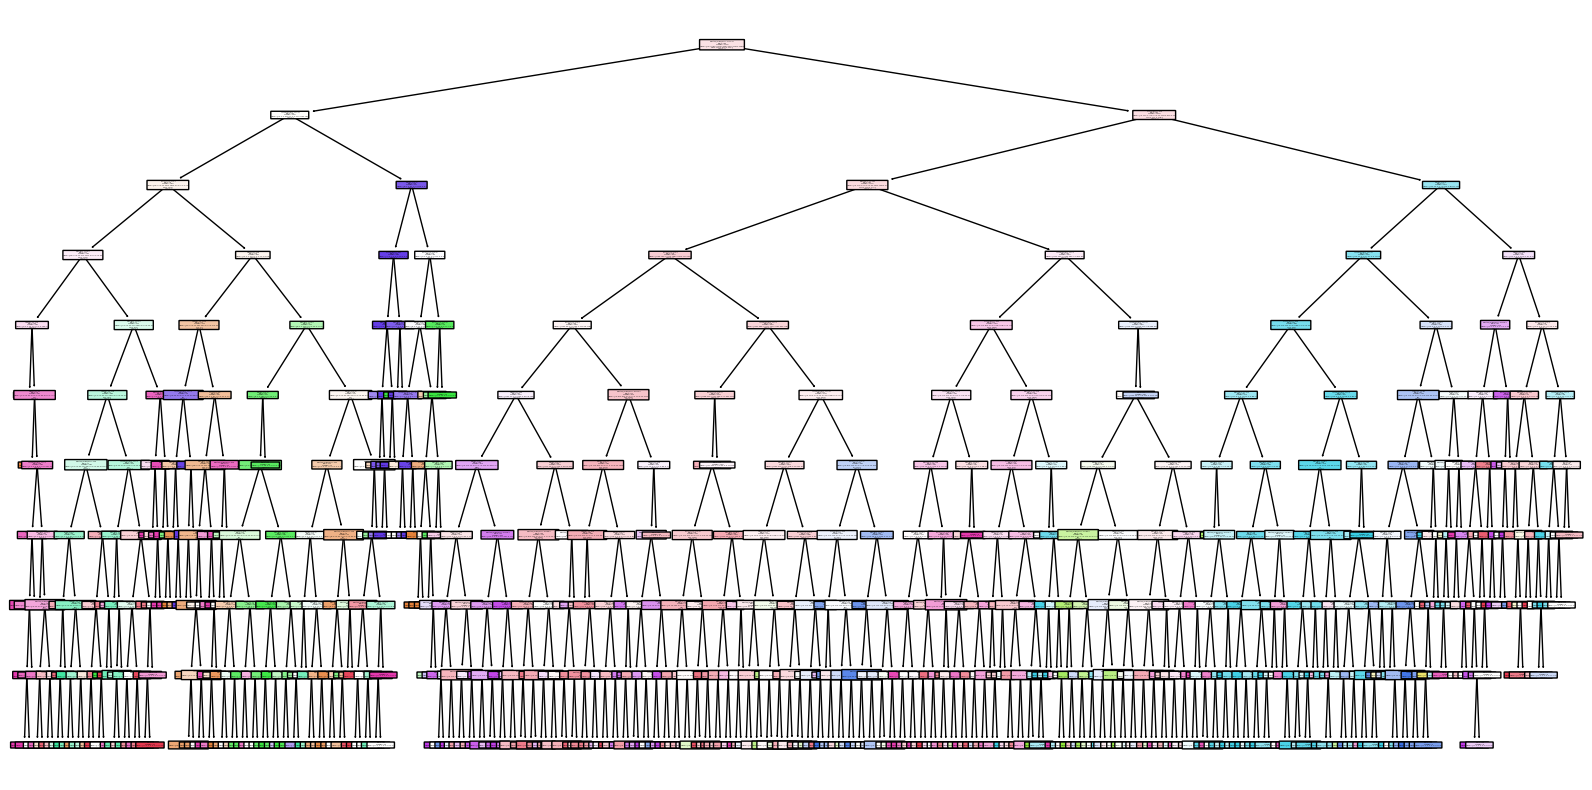

In [13]:
# Визуализация дерева
plt.figure(figsize=(20, 10))
plot_tree(best_model, 
          filled=True, 
          feature_names=X.columns, 
          class_names=[str(cls) for cls in best_model.classes_],
          rounded=True,
          proportion=False,
          precision=2)
plt.show()

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1.

2.

3.